# Etapa 3 - Machine Learning

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, ConfusionMatrixDisplay, precision_score, mean_squared_error, r2_score, explained_variance_score)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import ClusterCentroids

%matplotlib inline

warnings.filterwarnings('ignore')

# Functions

Metrics

In [2]:
def metrics(label_test, predict, reg=False):
    print('METRICS:')
    if reg is False:
        print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
        print(f"Recall score:\n{recall_score(label_test, predict, average='micro')}\n")
        print(f"Precison score:\n{precision_score(label_test, predict, average='micro', zero_division=0)}\n")
        print(f"F1-score:\n{f1_score(label_test, predict, average='micro')}\n")
        print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
        print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
        print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")
        ConfusionMatrixDisplay(confusion_matrix(label_test, predict)).plot(cmap=plt.cm.Blues)
    else:
        print(f"Explained variance score:\n{explained_variance_score(label_test, predict)}\n")
        print(f"R2 score:\n{r2_score(label_test, predict)}\n")
        print(f"Mean squared error:\n{mean_squared_error(label_test, predict)}\n")


ML

In [3]:
def ml(model, data_train, data_test, label_train, label_test, param=None, reg=False, sampling=False):
    if sampling is True:
        data_train, label_train = ClusterCentroids(n_jobs=4).fit_resample(data_train, label_train)
        data_test, label_test = ClusterCentroids(n_jobs=4).fit_resample(data_test, label_test)

    # k-fold
    kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    # Cross validation
    if reg is False:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=kfold, scoring='accuracy')
        print(f'Cross Validation Accuracy score: {np.mean(scores_scoring)}\n')
    else:
        scores_scoring = cross_val_score(model, X=data_train, y=label_train, cv=5, scoring='explained_variance')
        print(f'Cross Validation Explained_variance score: {np.mean(scores_scoring)}\n')

    # model training - FIT
    model.fit(data_train, label_train)

    # PREDICT
    predict = model.predict(X=data_test)
    if reg is False:
        base_model = accuracy_score(label_test, predict)
        print('Base Model Accuracy: {:.3f}\n'.format(base_model))
    else:
        base_model = explained_variance_score(label_test, predict)
        print('Base Model Explained variance: {:.3f}\n'.format(base_model))

    if param != None:
        ## OPTIMIZATION
        if reg is False:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring='accuracy', random_state=None,
                                         n_jobs=4)
        else:
            search = HalvingGridSearchCV(estimator=model, param_grid=param, cv=5, scoring='explained_variance', random_state=None,
                                         n_jobs=4)
        search.fit(X=data_train, y=label_train)

        # OPTI MODEL FITTED
        best_model = search.best_estimator_
        predict_opt = best_model.predict(X=data_test)
        if reg is False:
            opt_model = accuracy_score(label_test, predict_opt)
            print('Optimized Model Accuracy: {:.3f}\n'.format(opt_model))
        else:
            opt_model = explained_variance_score(label_test, predict_opt)
            print('Optimized Model Explained variance: {:.3f}\n'.format(opt_model))

        improv = ((opt_model-base_model)/base_model*100)
        print('Optimized model improved {:.3f}% over base model.\n'.format(improv))

        if improv >= 0:
            predict = predict_opt

    # Metrics
    metrics(label_test, predict, reg=reg)

The *ml* function will firstly do a cross validation to evaluate the model adaptation to the data. Secondly, it will fit the model and then predict the test set labels and it's corresponding accuracy. Lastly, it will do a hyperparameter optimization and then use the best parameters to predict the test set labels and it's accuracy.

# Models

In [4]:
rf = RandomForestClassifier(n_jobs=4)
nb = GaussianNB()
knn = KNeighborsClassifier(n_jobs=4)
voting = VotingClassifier(estimators=[('Random Forest', rf), ('Naive Bayes', nb), ('KNN', knn)], voting='soft', n_jobs=4)
nn = MLPClassifier(early_stopping=True)

# Hyperparameters

In [5]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2', 'auto'],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Binary Classification

### Load data

In [6]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/binary_class/rdk_fs.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_label_b = descriptors["activity"]
fingerprint_data_b = fingerprint.drop("activity", axis=1)
fingerprint_label_b = fingerprint["activity"]

## Descriptors

In [7]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_b, descriptors_label_b, test_size=0.3)

### Random Forest

Cross Validation Accuracy score: 0.8155547349629435

Base Model Accuracy: 0.820

Optimized Model Accuracy: 0.826

Optimized model improved 0.773% over base model.

METRICS:
Accuracy score:
0.8262899058097858

Recall score:
0.8262899058097858

Precison score:
0.8262899058097858

F1-score:
0.8262899058097858

MCC score:
0.6526684704678608

Confusion matrix:
[[5013  991]
 [1093 4900]]

Classification report:
              precision    recall  f1-score   support

           0      0.821     0.835     0.828      6004
           1      0.832     0.818     0.825      5993

    accuracy                          0.826     11997
   macro avg      0.826     0.826     0.826     11997
weighted avg      0.826     0.826     0.826     11997




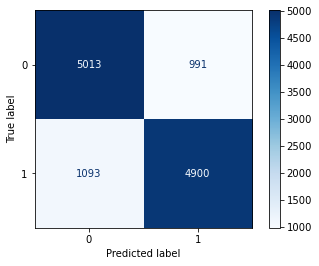

In [8]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.6991281490640299

Base Model Accuracy: 0.698

METRICS:
Accuracy score:
0.6984246061515379

Recall score:
0.6984246061515379

Precison score:
0.6984246061515379

F1-score:
0.6984246061515379

MCC score:
0.39727418501167416

Confusion matrix:
[[4338 1666]
 [1952 4041]]

Classification report:
              precision    recall  f1-score   support

           0      0.690     0.723     0.706      6004
           1      0.708     0.674     0.691      5993

    accuracy                          0.698     11997
   macro avg      0.699     0.698     0.698     11997
weighted avg      0.699     0.698     0.698     11997




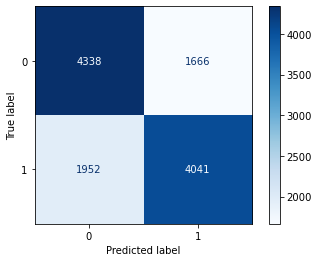

In [9]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors

Cross Validation Accuracy score: 0.7974775008628665

Base Model Accuracy: 0.796

Optimized Model Accuracy: 0.816

Optimized model improved 2.544% over base model.

METRICS:
Accuracy score:
0.8163707593565058

Recall score:
0.8163707593565058

Precison score:
0.8163707593565058

F1-score:
0.8163707593565058

MCC score:
0.6338826914503389

Confusion matrix:
[[5084  920]
 [1283 4710]]

Classification report:
              precision    recall  f1-score   support

           0      0.798     0.847     0.822      6004
           1      0.837     0.786     0.810      5993

    accuracy                          0.816     11997
   macro avg      0.818     0.816     0.816     11997
weighted avg      0.818     0.816     0.816     11997




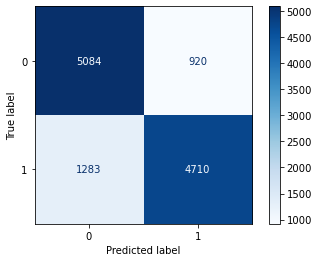

In [10]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.7710773455756053

Base Model Accuracy: 0.775

METRICS:
Accuracy score:
0.7746936734183546

Recall score:
0.7746936734183546

Precison score:
0.7746936734183546

F1-score:
0.7746936734183546

MCC score:
0.5511435376852348

Confusion matrix:
[[4894 1110]
 [1593 4400]]

Classification report:
              precision    recall  f1-score   support

           0      0.754     0.815     0.784      6004
           1      0.799     0.734     0.765      5993

    accuracy                          0.775     11997
   macro avg      0.776     0.775     0.774     11997
weighted avg      0.776     0.775     0.774     11997




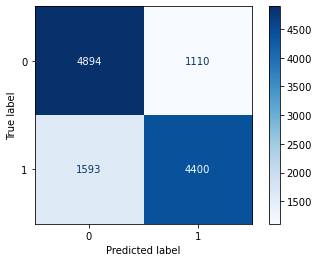

In [11]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network

Cross Validation Accuracy score: 0.8013001926223108

Base Model Accuracy: 0.802

Optimized Model Accuracy: 0.794

Optimized model improved -1.049% over base model.

METRICS:
Accuracy score:
0.8024506126531633

Recall score:
0.8024506126531633

Precison score:
0.8024506126531633

F1-score:
0.8024506126531633

MCC score:
0.605347566980494

Confusion matrix:
[[4936 1068]
 [1302 4691]]

Classification report:
              precision    recall  f1-score   support

           0      0.791     0.822     0.806      6004
           1      0.815     0.783     0.798      5993

    accuracy                          0.802     11997
   macro avg      0.803     0.802     0.802     11997
weighted avg      0.803     0.802     0.802     11997




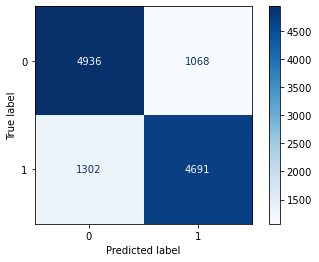

In [12]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

## Descriptors without feature selection

In [13]:
descriptors = pd.read_csv('../dataset/binary_class/descriptors_binary.csv', sep=',')

descriptors_data_b = descriptors.drop("activity", axis=1)
descriptors_data_b = StandardScaler().fit_transform(descriptors_data_b)
descriptors_label_b = descriptors["activity"]

### Random Forest

Cross Validation Accuracy score: 0.8145543585495828

Base Model Accuracy: 0.818

Optimized Model Accuracy: 0.827

Optimized model improved 1.141% over base model.

METRICS:
Accuracy score:
0.8273735100441777

Recall score:
0.8273735100441777

Precison score:
0.8273735100441777

F1-score:
0.8273735100441777

MCC score:
0.6549152581440504

Confusion matrix:
[[5038  966]
 [1105 4888]]

Classification report:
              precision    recall  f1-score   support

           0      0.820     0.839     0.830      6004
           1      0.835     0.816     0.825      5993

    accuracy                          0.827     11997
   macro avg      0.828     0.827     0.827     11997
weighted avg      0.828     0.827     0.827     11997




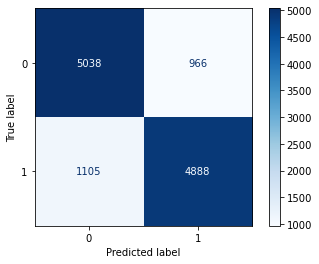

In [14]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

comparaçao

## Fingerprints

In [15]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_b, fingerprint_label_b, test_size=0.3)

### Random Forest

Cross Validation Accuracy score: 0.8027363636937924

Base Model Accuracy: 0.810

Optimized Model Accuracy: 0.817

Optimized model improved 0.927% over base model.

METRICS:
Accuracy score:
0.8171209469033925

Recall score:
0.8171209469033925

Precison score:
0.8171209469033925

F1-score:
0.8171209469033925

MCC score:
0.6343484489573095

Confusion matrix:
[[5017 1024]
 [1170 4786]]

Classification report:
              precision    recall  f1-score   support

           0      0.811     0.830     0.821      6041
           1      0.824     0.804     0.814      5956

    accuracy                          0.817     11997
   macro avg      0.817     0.817     0.817     11997
weighted avg      0.817     0.817     0.817     11997




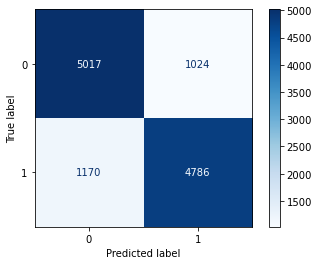

In [16]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.6630227568963758

Base Model Accuracy: 0.662

METRICS:
Accuracy score:
0.66208218721347

Recall score:
0.66208218721347

Precison score:
0.66208218721347

F1-score:
0.66208218721347

MCC score:
0.3242387827446583

Confusion matrix:
[[3969 2072]
 [1982 3974]]

Classification report:
              precision    recall  f1-score   support

           0      0.667     0.657     0.662      6041
           1      0.657     0.667     0.662      5956

    accuracy                          0.662     11997
   macro avg      0.662     0.662     0.662     11997
weighted avg      0.662     0.662     0.662     11997




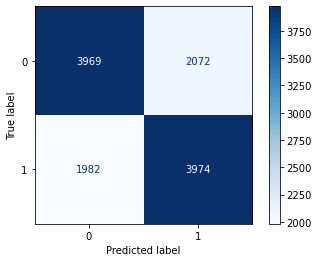

In [17]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors

Cross Validation Accuracy score: 0.7713357429148433

Base Model Accuracy: 0.783

Optimized Model Accuracy: 0.800

Optimized model improved 2.150% over base model.

METRICS:
Accuracy score:
0.7999499874968742

Recall score:
0.7999499874968742

Precison score:
0.7999499874968742

F1-score:
0.7999499874968742

MCC score:
0.6041289484881748

Confusion matrix:
[[5210  831]
 [1569 4387]]

Classification report:
              precision    recall  f1-score   support

           0      0.769     0.862     0.813      6041
           1      0.841     0.737     0.785      5956

    accuracy                          0.800     11997
   macro avg      0.805     0.800     0.799     11997
weighted avg      0.804     0.800     0.799     11997




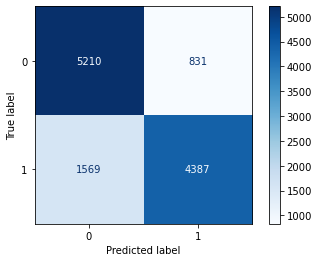

In [18]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.7455078074027026

Base Model Accuracy: 0.763

METRICS:
Accuracy score:
0.762690672668167

Recall score:
0.762690672668167

Precison score:
0.762690672668167

F1-score:
0.762690672668167

MCC score:
0.5256651358065707

Confusion matrix:
[[4741 1300]
 [1547 4409]]

Classification report:
              precision    recall  f1-score   support

           0      0.754     0.785     0.769      6041
           1      0.772     0.740     0.756      5956

    accuracy                          0.763     11997
   macro avg      0.763     0.763     0.763     11997
weighted avg      0.763     0.763     0.763     11997




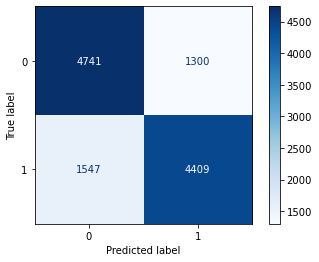

In [19]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network

Cross Validation Accuracy score: 0.7698713232936443

Base Model Accuracy: 0.788

Optimized Model Accuracy: 0.789

Optimized model improved 0.222% over base model.

METRICS:
Accuracy score:
0.7892806534967075

Recall score:
0.7892806534967075

Precison score:
0.7892806534967075

F1-score:
0.7892806534967075

MCC score:
0.5785534001016409

Confusion matrix:
[[4818 1223]
 [1305 4651]]

Classification report:
              precision    recall  f1-score   support

           0      0.787     0.798     0.792      6041
           1      0.792     0.781     0.786      5956

    accuracy                          0.789     11997
   macro avg      0.789     0.789     0.789     11997
weighted avg      0.789     0.789     0.789     11997




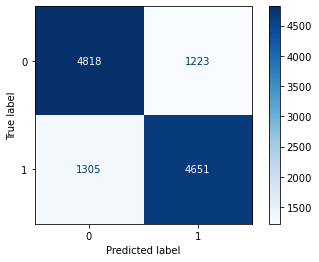

In [20]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

## Comparation

TABLE HERE

# Multiclass

### Load data

In [21]:
descriptors = pd.read_csv('../dataset/multiclass/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/multiclass/rdk_fs.csv', sep=',')

descriptors_data_m = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_m = descriptors["Activity at 46.23 uM"]
fingerprint_data_m = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_m = fingerprint["Activity at 46.23 uM"]

## Descriptors

In [22]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_m, descriptors_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation Accuracy score: 0.566564283391277

Base Model Accuracy: 0.571

Optimized Model Accuracy: 0.573

Optimized model improved 0.204% over base model.

METRICS:
Accuracy score:
0.5725611282650421

Recall score:
0.5725611282650421

Precison score:
0.5725611282650421

F1-score:
0.5725611282650421

MCC score:
0.35238563936412665

Confusion matrix:
[[ 125 1167  313    5]
 [ 189 3326  892   18]
 [  13  878 3308  174]
 [   2  178 1293  102]]

Classification report:
              precision    recall  f1-score   support

           0      0.380     0.078     0.129      1610
           1      0.599     0.752     0.667      4425
           2      0.570     0.756     0.650      4373
           3      0.341     0.065     0.109      1575

    accuracy                          0.573     11983
   macro avg      0.473     0.413     0.389     11983
weighted avg      0.525     0.573     0.515     11983




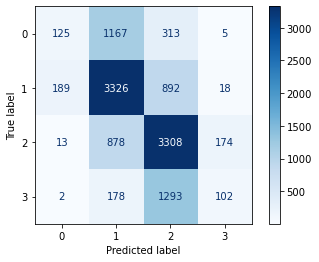

In [23]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.39634440851061215

Base Model Accuracy: 0.391

METRICS:
Accuracy score:
0.39105399315697237

Recall score:
0.39105399315697237

Precison score:
0.39105399315697237

F1-score:
0.39105399315697237

MCC score:
0.15590417697518766

Confusion matrix:
[[ 244  831  299  236]
 [ 427 2547  909  542]
 [ 135 1284 1090 1864]
 [  42  342  386  805]]

Classification report:
              precision    recall  f1-score   support

           0      0.288     0.152     0.199      1610
           1      0.509     0.576     0.540      4425
           2      0.406     0.249     0.309      4373
           3      0.234     0.511     0.321      1575

    accuracy                          0.391     11983
   macro avg      0.359     0.372     0.342     11983
weighted avg      0.406     0.391     0.381     11983




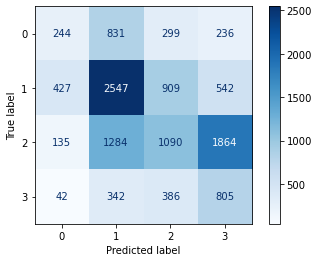

In [24]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors Classifier

Cross Validation Accuracy score: 0.5139499115812788

Base Model Accuracy: 0.523

Optimized Model Accuracy: 0.556

Optimized model improved 6.205% over base model.

METRICS:
Accuracy score:
0.5556204623216223

Recall score:
0.5556204623216223

Precison score:
0.5556204623216223

F1-score:
0.5556204623216223

MCC score:
0.32869168708083146

Confusion matrix:
[[ 156 1091  347   16]
 [ 220 3121 1035   49]
 [  23  816 3225  309]
 [  10  157 1252  156]]

Classification report:
              precision    recall  f1-score   support

           0      0.381     0.097     0.155      1610
           1      0.602     0.705     0.650      4425
           2      0.550     0.737     0.630      4373
           3      0.294     0.099     0.148      1575

    accuracy                          0.556     11983
   macro avg      0.457     0.410     0.396     11983
weighted avg      0.513     0.556     0.510     11983




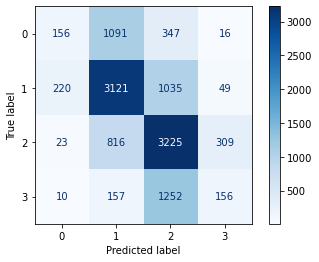

In [25]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.49574350408343265

Base Model Accuracy: 0.496

METRICS:
Accuracy score:
0.4963698572978386

Recall score:
0.4963698572978386

Precison score:
0.4963698572978386

F1-score:
0.4963698572978386

MCC score:
0.26193665415625433

Confusion matrix:
[[ 176 1026  304  104]
 [ 265 3035  893  232]
 [  66 1023 2244 1040]
 [  19  231  832  493]]

Classification report:
              precision    recall  f1-score   support

           0      0.335     0.109     0.165      1610
           1      0.571     0.686     0.623      4425
           2      0.525     0.513     0.519      4373
           3      0.264     0.313     0.286      1575

    accuracy                          0.496     11983
   macro avg      0.424     0.405     0.398     11983
weighted avg      0.482     0.496     0.479     11983




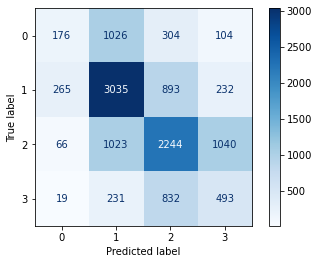

In [26]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network Classifier

Cross Validation Accuracy score: 0.5585523267135077

Base Model Accuracy: 0.564

Optimized Model Accuracy: 0.564

Optimized model improved 0.030% over base model.

METRICS:
Accuracy score:
0.5638821664024034

Recall score:
0.5638821664024034

Precison score:
0.5638821664024034

F1-score:
0.5638821664024034

MCC score:
0.33623278578167

Confusion matrix:
[[  47 1221  332   10]
 [  64 3384  968    9]
 [  13  982 3236  142]
 [   4  231 1250   90]]

Classification report:
              precision    recall  f1-score   support

           0      0.367     0.029     0.054      1610
           1      0.582     0.765     0.661      4425
           2      0.559     0.740     0.637      4373
           3      0.359     0.057     0.099      1575

    accuracy                          0.564     11983
   macro avg      0.467     0.398     0.363     11983
weighted avg      0.515     0.564     0.497     11983




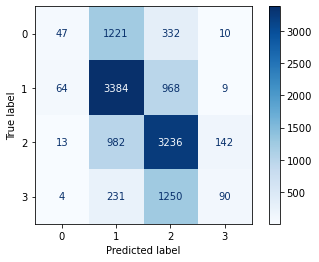

In [27]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

### Undersampling

Cross Validation Accuracy score: 0.4644504748982361

Base Model Accuracy: 0.515

Optimized Model Accuracy: 0.519

Optimized model improved 0.709% over base model.

METRICS:
Accuracy score:
0.5185714285714286

Recall score:
0.5185714285714286

Precison score:
0.5185714285714286

F1-score:
0.5185714285714286

MCC score:
0.3581802584663198

Confusion matrix:
[[824 450 134 167]
 [427 803 236 109]
 [132 275 720 448]
 [123  95 437 920]]

Classification report:
              precision    recall  f1-score   support

           0      0.547     0.523     0.535      1575
           1      0.495     0.510     0.502      1575
           2      0.472     0.457     0.464      1575
           3      0.560     0.584     0.572      1575

    accuracy                          0.519      6300
   macro avg      0.518     0.519     0.518      6300
weighted avg      0.518     0.519     0.518      6300




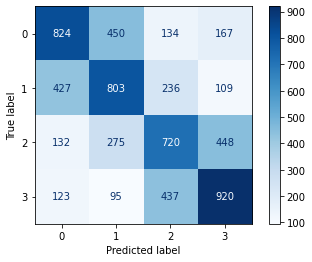

In [28]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, sampling=True)

## Fingerprints

In [29]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_m, fingerprint_label_m, test_size=0.3)

### Random Forest Classifier

Cross Validation Accuracy score: 0.5495744169366822

Base Model Accuracy: 0.555

Optimized Model Accuracy: 0.551

Optimized model improved -0.856% over base model.

METRICS:
Accuracy score:
0.5554535592088793

Recall score:
0.5554535592088793

Precison score:
0.5554535592088793

F1-score:
0.5554535592088793

MCC score:
0.33282813093463337

Confusion matrix:
[[ 219 1014  299   14]
 [ 396 3034  890   56]
 [  63  777 3178  413]
 [   9  198 1198  225]]

Classification report:
              precision    recall  f1-score   support

           0      0.319     0.142     0.196      1546
           1      0.604     0.693     0.646      4376
           2      0.571     0.717     0.636      4431
           3      0.318     0.138     0.192      1630

    accuracy                          0.555     11983
   macro avg      0.453     0.423     0.418     11983
weighted avg      0.516     0.555     0.522     11983




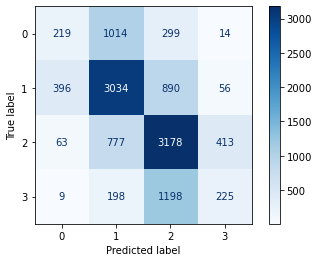

In [30]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf)

### Gaussian Naive Bayes

Cross Validation Accuracy score: 0.33732711907472385

Base Model Accuracy: 0.333

METRICS:
Accuracy score:
0.332804806809647

Recall score:
0.332804806809647

Precison score:
0.332804806809647

F1-score:
0.332804806809647

MCC score:
0.11671539616624753

Confusion matrix:
[[ 478  564  245  259]
 [1264 1666  784  662]
 [ 551 1031 1019 1830]
 [ 176  283  346  825]]

Classification report:
              precision    recall  f1-score   support

           0      0.194     0.309     0.238      1546
           1      0.470     0.381     0.421      4376
           2      0.426     0.230     0.299      4431
           3      0.231     0.506     0.317      1630

    accuracy                          0.333     11983
   macro avg      0.330     0.357     0.319     11983
weighted avg      0.385     0.333     0.338     11983




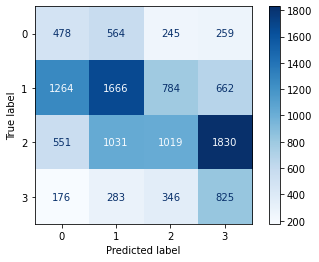

In [31]:
ml(nb, data_train, data_test, label_train, label_test, param=None)

### K Nearest Neighbors Classifier

Cross Validation Accuracy score: 0.5155589058544683

Base Model Accuracy: 0.514

Optimized Model Accuracy: 0.539

Optimized model improved 4.852% over base model.

METRICS:
Accuracy score:
0.5391805057164316

Recall score:
0.5391805057164316

Precison score:
0.5391805057164316

F1-score:
0.5391805057164316

MCC score:
0.30876999095663044

Confusion matrix:
[[ 208  939  376   23]
 [ 372 2681 1241   82]
 [  52  625 3394  360]
 [   6  146 1300  178]]

Classification report:
              precision    recall  f1-score   support

           0      0.326     0.135     0.190      1546
           1      0.611     0.613     0.612      4376
           2      0.538     0.766     0.632      4431
           3      0.277     0.109     0.157      1630

    accuracy                          0.539     11983
   macro avg      0.438     0.406     0.398     11983
weighted avg      0.502     0.539     0.503     11983




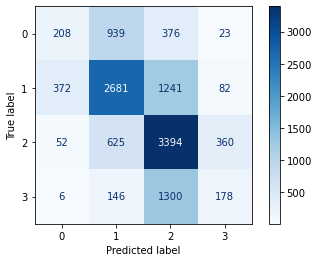

In [32]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn)

### Voting Classifier
This model will include all the previous models.

Cross Validation Accuracy score: 0.471134812258307

Base Model Accuracy: 0.473

METRICS:
Accuracy score:
0.47308687307018277

Recall score:
0.47308687307018277

Precison score:
0.47308687307018277

F1-score:
0.47308687307018277

MCC score:
0.24215871519076118

Confusion matrix:
[[ 303  857  263  123]
 [ 599 2510  924  343]
 [ 210  778 2363 1080]
 [  46  185  906  493]]

Classification report:
              precision    recall  f1-score   support

           0      0.262     0.196     0.224      1546
           1      0.580     0.574     0.577      4376
           2      0.530     0.533     0.532      4431
           3      0.242     0.302     0.269      1630

    accuracy                          0.473     11983
   macro avg      0.403     0.401     0.400     11983
weighted avg      0.474     0.473     0.473     11983




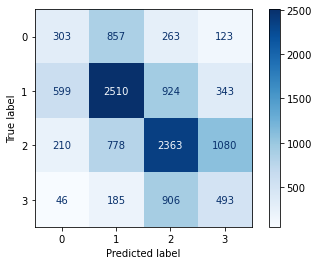

In [33]:
ml(voting, data_train, data_test, label_train, label_test, param=None)

### Neural Network Classifier

Cross Validation Accuracy score: 0.5333715423495097

Base Model Accuracy: 0.542

Optimized Model Accuracy: 0.538

Optimized model improved -0.693% over base model.

METRICS:
Accuracy score:
0.5416840524075774

Recall score:
0.5416840524075774

Precison score:
0.5416840524075774

F1-score:
0.5416840524075774

MCC score:
0.29785641700120224

Confusion matrix:
[[  35 1173  334    4]
 [  74 3255 1041    6]
 [  24 1188 3163   56]
 [   8  284 1300   38]]

Classification report:
              precision    recall  f1-score   support

           0      0.248     0.023     0.041      1546
           1      0.552     0.744     0.634      4376
           2      0.542     0.714     0.616      4431
           3      0.365     0.023     0.044      1630

    accuracy                          0.542     11983
   macro avg      0.427     0.376     0.334     11983
weighted avg      0.484     0.542     0.470     11983




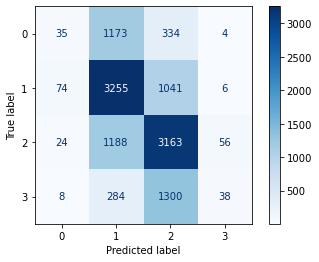

In [34]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn)

## Regression

### Load data

In [4]:
descriptors = pd.read_csv('../dataset/regression/descriptors_fs.csv', sep=',')
fingerprint = pd.read_csv('../dataset/regression/rdk_fs.csv', sep=',')

descriptors_data_r = descriptors.drop("Activity at 46.23 uM", axis=1)
descriptors_label_r = descriptors["Activity at 46.23 uM"]
fingerprint_data_r = fingerprint.drop("Activity at 46.23 uM", axis=1)
fingerprint_label_r = fingerprint["Activity at 46.23 uM"]

### Models

In [5]:
rf = RandomForestRegressor(n_jobs=4)
lr = LinearRegression(n_jobs=4)
knn = KNeighborsRegressor(n_jobs=4)
voting = VotingRegressor(estimators=[('Random Forest', rf), ('Linear Regression', lr), ('KNN', knn)], n_jobs=4)
nn = MLPRegressor(early_stopping=True)

### Hyperparameters

In [6]:
params_rf = {'n_estimators': range(50, 251, 25), 'criterion': ['squared_error', 'absolute_error'], 'max_features': ['sqrt', 'log2', 'auto'],
          'bootstrap': [True, False]}
params_knn = {'n_neighbors': range(2, 17, 2), 'weights': ['distance', 'uniform'], 'leaf_size': range(10, 50, 10), 'p': [1, 2]}
params_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive']}

## Descriptors

In [7]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(descriptors_data_r, descriptors_label_r, test_size=0.3)

### Random Forest Regressor

In [9]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, reg=True)

Cross Validation Explained_variance score: 0.4595881293206804

Base Model Explained variance: 0.463

Optimized Model Explained variance: 0.505

Optimized model improved 9.143% over base model.

METRICS:
Explained variance score:
0.5051394792158217

R2 score:
0.5050983176608482

Mean squared error:
909.6930550514986



### Linear Regression

In [10]:
ml(lr, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: 0.31147396240684816

Base Model Explained variance: 0.310

METRICS:
Explained variance score:
0.309941220888048

R2 score:
0.3099389269632661

Mean squared error:
1268.4211594025548



### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn, reg=True)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, param=None, reg=True)

### Neural Network Regressor

In [11]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn, reg=True)

Cross Validation Explained_variance score: 0.40128076906703436

Base Model Explained variance: 0.411



/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Optimized Model Explained variance: 0.408

Optimized model improved -0.583% over base model.

METRICS:
Explained variance score:
0.4108234677334893

R2 score:
0.4108194374814267

Mean squared error:
1082.9897836701707



## Fingerprints

In [12]:
# SPLIT
data_train, data_test, label_train, label_test = train_test_split(fingerprint_data_r, fingerprint_label_r, test_size=0.3)

### Random Forest Regressor

In [15]:
ml(rf, data_train, data_test, label_train, label_test, param=params_rf, reg=True)

Cross Validation Explained_variance score: 0.42319482568503536

Base Model Explained variance: 0.428

Optimized Model Explained variance: 0.433

Optimized model improved 1.254% over base model.

METRICS:
Explained variance score:
0.43328413891459105

R2 score:
0.43291895732151187

Mean squared error:
1038.067293327646



### Linear Regression

In [14]:
ml(lr, data_train, data_test, label_train, label_test, param=None, reg=True)

Cross Validation Explained_variance score: 0.18972115174306353

Base Model Explained variance: 0.186

METRICS:
Explained variance score:
0.18565434984019946

R2 score:
0.18541961806981788

Mean squared error:
1491.1259390264595



### K Nearest Neighbors Regressor

In [ ]:
ml(knn, data_train, data_test, label_train, label_test, param=params_knn, reg=True)

### Voting Regressor

In [ ]:
ml(voting, data_train, data_test, label_train, label_test, param=None, reg=True)

### Neural Network Regressor

In [ ]:
ml(nn, data_train, data_test, label_train, label_test, param=params_nn, reg=True)